# Recovery Statistics and Mosaic Analysis

Compute recovery cases where code execution fails (`code_correct=False`) but code simulation succeeds (`sim_correct=True`). Visualize contingency tables with mosaic plots and summarize recovery rates by model, problem kind, and digit.

In [18]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.contingency_tables import Table2x2, mcnemar

from src.exps_performance.logger import create_big_df

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.dpi"] = 150
sns.set_theme(style="whitegrid")

RESULTS_ROOT = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/results")

In [19]:
def find_jsonl_files(root: Path = RESULTS_ROOT) -> List[Path]:
    if not root.exists():
        raise FileNotFoundError(f"Results root not found: {root}")
    files = sorted(root.rglob("res.jsonl"))
    if not files:
        raise FileNotFoundError(f"No res.jsonl files found under {root}")
    return files


def load_results() -> pd.DataFrame:
    files = find_jsonl_files()
    df = create_big_df(files)
    # Keep core columns; tolerate missing ones gracefully
    expected_cols = [
        "model",
        "kind",
        "digit",
        "seed",
        "code_correct",
        "sim_correct",
    ]
    missing = [c for c in expected_cols if c not in df.columns]
    if missing:
        print("[warn] Missing columns:", missing)
    # Coerce booleans with safe defaults
    df = df.assign(
        code_correct=df.get("code_correct", False).fillna(False).astype(bool),
        sim_correct=df.get("sim_correct", False).fillna(False).astype(bool),
    )
    return df


df = load_results()
print(f"Loaded {len(df):,} rows from {len(find_jsonl_files())} files")
df.head(3)

Loaded 18,100 rows from 14 files


,request_id,unique_tag,index_in_kind,model,seed,exp_id,digit,kind,question,answer,nl_question,nl_answer,nl_reasoning,nl_correct,nl_parse_err,nl_err_msg,code_question,code_answer,code_correct,code_parse_err,code_gen_err,code_err_msg,sim_code,sim_question,sim_reasoning,sim_answer,sim_correct,sim_parse_err,sim_err_msg,controlsim_question,controlsim_reasoning,controlsim_answer,controlsim_correct,controlsim_parse_err,controlsim_err_msg
0,4e378049b64ca7ef76f1d3a4053360d127b82e05,0f1f2bf0350e1ac7b34f7a3a071f20642e7f1421,1,anthropic/claude-haiku-4.5,0,run_20260104_032047,6,kmp_matcher,,2,Description: You are going to be given a set o...,"```json\n{\n ""Answer"": ""-1"",\n ""simulation"":...",KMP (Knuth-Morris-Pratt) matcher attempts to f...,False,False,ok,\ndef solution() -> int:\n def kmp_matcher(...,,False,True,"type_check_failed,invalid syntax (<string>, li...","type_check_failed,invalid syntax (<string>, li...",```python\ndef solution() -> int:\n def kmp...,Description: You are going to be given a set o...,,"```json\n{\n ""Answer"": ""-1"",\n ""code"": ""```p...",False,ok,ok,Simulate the execution of the provided code: `...,The function executes the KMP (Knuth-Morris-Pr...,"```json\n{\n ""Answer"": ""-1"",\n ""simulation"":...",False,False,ok
1,157d673da0ce11c800dfcc3ebbb5804c41241ea5,839fe310a6313b41e8c865eebf7858920a239fbc,2,anthropic/claude-haiku-4.5,0,run_20260104_032047,13,kmp_matcher,,1,Description: You are going to be given a set o...,"```json\n{\n ""Answer"": ""-1"",\n ""simulation"":...","To solve this KMP matcher problem, I need to s...",False,False,ok,"\ndef solution() -> int:\n string = [0, 0, ...",-1,False,True,"ok,ok","ok,ok",```python\ndef solution() -> int:\n string ...,Description: You are going to be given a set o...,,"```json\n{\n ""Answer"": ""0"",\n ""code"": ""```py...",False,ok,ok,Simulate the execution of the provided code: `...,This code implements the KMP (Knuth-Morris-Pra...,"```json\n{\n ""Answer"": ""-1"",\n ""simulation"":...",False,False,ok
2,c57035d5243f12be992e8fa8c3911df6112280bf,85f74da860cb7b0507f492a1f56a5ebd041b41b5,3,anthropic/claude-haiku-4.5,0,run_20260104_032047,13,kmp_matcher,,8,Description: You are going to be given a set o...,"```json\n{\n ""Answer"": ""No match found"",\n ""...",In the KMP (Knuth-Morris-Pratt) matcher algori...,False,False,ok,\ndef solution() -> int:\n def build_failur...,,False,True,"type_check_failed,invalid syntax (<string>, li...","type_check_failed,invalid syntax (<string>, li...",```python\ndef solution() -> int:\n def bui...,Description: You are going to be given a set o...,,"```json\n{\n ""Answer"": ""-1"",\n ""code"": ""```p...",False,ok,ok,Simulate the execution of the provided code: `...,The code implements the KMP (Knuth-Morris-Prat...,"```json\n{\n ""Answer"": ""-1"",\n ""simulation"":...",False,False,ok


In [20]:
# Derive recovery flag

df = df.copy()
df["code_exec"] = df["code_correct"].astype(bool)
df["code_sim"] = df["sim_correct"].astype(bool)
df["recovery"] = (~df["code_exec"]) & (df["code_sim"])

summary_overall = {
    "rows": len(df),
    "code_exec_acc": df["code_exec"].mean(),
    "code_sim_acc": df["code_sim"].mean(),
    "recovery_rate": df["recovery"].mean(),
    "recovery_count": int(df["recovery"].sum()),
}
summary_overall

{'rows': 18100,
 'code_exec_acc': 0.2814917127071823,
 'code_sim_acc': 0.3013812154696133,
 'recovery_rate': 0.14303867403314918,
 'recovery_count': 2589}

In [21]:
# Contingency table: code_exec vs code_sim
ct_raw = (
    pd.crosstab(df["code_exec"], df["code_sim"])
    .reindex(index=[False, True], columns=[False, True], fill_value=0)
)
ct_labeled = ct_raw.copy()
ct_labeled.index = ["code_exec:incorrect", "code_exec:correct"]
ct_labeled.columns = ["code_sim:incorrect", "code_sim:correct"]

row_percent = (ct_raw.div(ct_raw.sum(axis=1), axis=0) * 100).round(2)
row_percent.index = ct_labeled.index
row_percent.columns = ct_labeled.columns

col_percent = (ct_raw.div(ct_raw.sum(axis=0), axis=1) * 100).round(2)
col_percent.index = ct_labeled.index
col_percent.columns = ct_labeled.columns

overall_percent = (ct_raw / ct_raw.values.sum() * 100).round(2)
overall_percent.index = ct_labeled.index
overall_percent.columns = ct_labeled.columns

recovery_rate_overall = ct_raw.loc[False, True] / ct_raw.loc[False].sum()

display(
    {
        "contingency_counts": ct_labeled,
        "row_percent": row_percent,
        "column_percent": col_percent,
        "overall_percent": overall_percent,
        "recovery_rate": pd.DataFrame({"recovery_rate": [recovery_rate_overall]}),
    }
)


{'contingency_counts':                      code_sim:incorrect  code_sim:correct
 code_exec:incorrect               10416              2589
 code_exec:correct                  2229              2866,
 'row_percent':                      code_sim:incorrect  code_sim:correct
 code_exec:incorrect               80.09             19.91
 code_exec:correct                 43.75             56.25,
 'column_percent':                      code_sim:incorrect  code_sim:correct
 code_exec:incorrect               82.37             47.46
 code_exec:correct                 17.63             52.54,
 'overall_percent':                      code_sim:incorrect  code_sim:correct
 code_exec:incorrect               57.55             14.30
 code_exec:correct                 12.31             15.83,
 'recovery_rate':    recovery_rate
 0       0.199077}

In [22]:
# Statistical tests for the contingency table
# Order of ct_raw rows/cols is [code_exec=False/True] x [code_sim=False/True]
# Guard against zero cells by adding a small continuity correction when needed.
_table_raw = ct_raw.values.astype(float)
zero_cells = (_table_raw == 0).any()
table_for_stats = _table_raw + 0.5 if zero_cells else _table_raw

table2x2 = Table2x2(table_for_stats)

odds_ratio = table2x2.oddsratio
or_ci_low, or_ci_high = table2x2.oddsratio_confint()
or_p_value = table2x2.oddsratio_pvalue()

try:
    risk_ratio = table2x2.riskratio
    rr_ci_low, rr_ci_high = table2x2.riskratio_confint()
except Exception:
    risk_ratio, rr_ci_low, rr_ci_high = float("nan"), float("nan"), float("nan")

try:
    risk_diff = table2x2.riskdiff
    rd_ci_low, rd_ci_high = table2x2.riskdiff_confint()
except Exception:
    risk_diff, rd_ci_low, rd_ci_high = float("nan"), float("nan"), float("nan")

# McNemar requires discordant pairs; handle the degenerate case gracefully.
b = ct_raw.loc[False, True]
c = ct_raw.loc[True, False]
if (b + c) == 0:
    mcnemar_stat = float("nan")
    mcnemar_p_value = float("nan")
else:
    mcnemar_res = mcnemar(ct_raw)
    mcnemar_stat = mcnemar_res.statistic
    mcnemar_p_value = mcnemar_res.pvalue

conditional_probabilities = pd.DataFrame(
    {
        "P(code_sim=True | code_exec=False)": [ct_raw.loc[False, True] / max(ct_raw.loc[False].sum(), 1)],
        "P(code_sim=True | code_exec=True)": [ct_raw.loc[True, True] / max(ct_raw.loc[True].sum(), 1)],
        "P(code_sim=False | code_exec=False)": [ct_raw.loc[False, False] / max(ct_raw.loc[False].sum(), 1)],
        "P(code_sim=False | code_exec=True)": [ct_raw.loc[True, False] / max(ct_raw.loc[True].sum(), 1)],
    }
)

stats_summary = pd.DataFrame(
    {
        "odds_ratio": [odds_ratio],
        "odds_ratio_ci_low": [or_ci_low],
        "odds_ratio_ci_high": [or_ci_high],
        "odds_ratio_p_value": [or_p_value],
        "risk_ratio": [risk_ratio],
        "risk_ratio_ci_low": [rr_ci_low],
        "risk_ratio_ci_high": [rr_ci_high],
        "risk_diff": [risk_diff],
        "risk_diff_ci_low": [rd_ci_low],
        "risk_diff_ci_high": [rd_ci_high],
        "mcnemar_stat": [mcnemar_stat],
        "mcnemar_p_value": [mcnemar_p_value],
        "zero_cell_correction": [zero_cells],
    }
)

display({"stats_summary": stats_summary, "conditional_probabilities": conditional_probabilities})


{'stats_summary':    odds_ratio  odds_ratio_ci_low  odds_ratio_ci_high  odds_ratio_p_value  \
 0    5.172911           4.822629            5.548636                 0.0   
 
    risk_ratio  risk_ratio_ci_low  risk_ratio_ci_high  risk_diff  \
 0    1.830732           1.772556            1.890817        NaN   
 
    risk_diff_ci_low  risk_diff_ci_high  mcnemar_stat  mcnemar_p_value  \
 0               NaN                NaN        2229.0     2.287201e-07   
 
    zero_cell_correction  
 0                 False  ,
 'conditional_probabilities':    P(code_sim=True | code_exec=False)  P(code_sim=True | code_exec=True)  \
 0                            0.199077                           0.562512   
 
    P(code_sim=False | code_exec=False)  P(code_sim=False | code_exec=True)  
 0                             0.800923                            0.437488  }

In [23]:
# Interpretation helper (overall)
recovery_rate_pct = recovery_rate_overall * 100
p_sim_given_exec_true = conditional_probabilities["P(code_sim=True | code_exec=True)"].iloc[0]
p_sim_given_exec_false = conditional_probabilities["P(code_sim=True | code_exec=False)"].iloc[0]

mcnemar_text = (
    f"McNemar test: chi2 = {mcnemar_stat:.3f}, p = {mcnemar_p_value:.3g}; "
    "low p suggests asymmetry between exec vs sim outcomes."
    if pd.notna(mcnemar_p_value)
    else "McNemar test: not applicable (no discordant pairs)."
)
correction_note = " (continuity correction applied due to zero cell)" if zero_cells else ""

rr_text = (
    f"Risk ratio: {risk_ratio:.2f} (95% CI: {rr_ci_low:.2f} to {rr_ci_high:.2f});"
    if pd.notna(risk_ratio)
    else "Risk ratio: n/a (not available in this statsmodels version)."
)
rd_text = (
    f"risk diff: {risk_diff:.3f} ({rd_ci_low:.3f}, {rd_ci_high:.3f})."
    if pd.notna(risk_diff)
    else "risk diff: n/a."
)

interpretation = f"""
- Recovery rate: {recovery_rate_pct:.2f}% of code_exec failures are corrected by code_sim.
- Odds ratio{correction_note}: {odds_ratio:.2f} (95% CI: {or_ci_low:.2f} to {or_ci_high:.2f}); p = {or_p_value:.3g}.
  Values >1 favor code_sim correctness when code_exec fails.
- {mcnemar_text}
- {rr_text} {rd_text}
- Conditional correctness: P(code_sim=True | code_exec=False) = {p_sim_given_exec_false:.2%}; P(code_sim=True | code_exec=True) = {p_sim_given_exec_true:.2%}.
  Gap = {(p_sim_given_exec_false - p_sim_given_exec_true):.2%}, highlighting recovery uplift when execution fails.
"""

print(interpretation)



- Recovery rate: 19.91% of code_exec failures are corrected by code_sim.
- Odds ratio: 5.17 (95% CI: 4.82 to 5.55); p = 0.
  Values >1 favor code_sim correctness when code_exec fails.
- McNemar test: chi2 = 2229.000, p = 2.29e-07; low p suggests asymmetry between exec vs sim outcomes.
- Risk ratio: 1.83 (95% CI: 1.77 to 1.89); risk diff: n/a.
- Conditional correctness: P(code_sim=True | code_exec=False) = 19.91%; P(code_sim=True | code_exec=True) = 56.25%.
  Gap = -36.34%, highlighting recovery uplift when execution fails.



## Interpretation guide
- The `contingency_counts` table shows raw counts; the recovery cell is `code_exec:incorrect` ∩ `code_sim:correct`.
- `recovery_rate` reports P(code_sim correct | code_exec incorrect); higher means better recovery when execution fails.
- `stats_summary` provides odds ratio, risk ratio/difference, and McNemar p-value; odds ratio > 1 with small p-values indicates simulation succeeds disproportionately when execution fails.
- `conditional_probabilities` contrasts P(code_sim correct) conditioned on execution success vs failure; the gap highlights recovery uplift.
- Use row/column/overall percents to see whether recovery is driven by rare slices or broad effects across the dataset.


In [24]:
def recovery_table(df: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    grouped = (
        df.groupby(group_cols)
        .agg(
            total=("recovery", "size"),
            recovery_count=("recovery", "sum"),
            recovery_rate=("recovery", "mean"),
            code_exec_acc=("code_exec", "mean"),
            code_sim_acc=("code_sim", "mean"),
        )
        .reset_index()
    )
    return grouped.sort_values("recovery_rate", ascending=False)


rates_by_model = recovery_table(df, ["model"])
rates_by_kind = recovery_table(df, ["kind"])
rates_by_digit = recovery_table(df, ["digit"])
rates_by_model_kind = recovery_table(df, ["model", "kind"])
rates_by_model_digit = recovery_table(df, ["model", "digit"])
rates_by_kind_digit = recovery_table(df, ["kind", "digit"])

rates_by_model.head(10)

,model,total,recovery_count,recovery_rate,code_exec_acc,code_sim_acc
5,qwen/qwen-2.5-coder-32b-instruct,4316,1229,0.284754,0.189991,0.455978
2,meta-llama/llama-3.1-405b-instruct,3036,550,0.181159,0.102767,0.226943
3,mistralai/ministral-14b-2512,4960,588,0.118548,0.143952,0.188306
4,openai/gpt-4o-mini,709,36,0.050776,0.386460,0.187588
0,anthropic/claude-haiku-4.5,4626,172,0.037181,0.576740,0.337441
1,google/gemini-2.5-flash,453,14,0.030905,0.677704,0.375276


In [25]:
display(
    {
        "overall": pd.DataFrame([summary_overall]),
        "by_model_top10": rates_by_model.head(10),
        "by_kind": rates_by_kind,
        "by_digit": rates_by_digit,
    }
)

# High-signal combinations
high_signal_kind = rates_by_kind.sort_values("recovery_rate", ascending=False).head(5)
high_signal_model = rates_by_model.sort_values("recovery_rate", ascending=False).head(5)
high_signal_model_kind = rates_by_model_kind.sort_values("recovery_rate", ascending=False).head(10)

print("Top kinds by recovery rate:")
display(high_signal_kind)
print("Top models by recovery rate:")
display(high_signal_model)
print("Top model-kind pairs by recovery rate:")
display(high_signal_model_kind)


{'overall':     rows  code_exec_acc  code_sim_acc  recovery_rate  recovery_count
 0  18100       0.281492      0.301381       0.143039            2589,
 'by_model_top10':                                 model  total  recovery_count  recovery_rate  \
 5    qwen/qwen-2.5-coder-32b-instruct   4316            1229       0.284754   
 2  meta-llama/llama-3.1-405b-instruct   3036             550       0.181159   
 3        mistralai/ministral-14b-2512   4960             588       0.118548   
 4                  openai/gpt-4o-mini    709              36       0.050776   
 0          anthropic/claude-haiku-4.5   4626             172       0.037181   
 1             google/gemini-2.5-flash    453              14       0.030905   
 
    code_exec_acc  code_sim_acc  
 5       0.189991      0.455978  
 2       0.102767      0.226943  
 3       0.143952      0.188306  
 4       0.386460      0.187588  
 0       0.576740      0.337441  
 1       0.677704      0.375276  ,
 'by_kind':                  

Top kinds by recovery rate:


,kind,total,recovery_count,recovery_rate,code_exec_acc,code_sim_acc
38,segments_intersect,531,169,0.318267,0.265537,0.536723
16,gsm8k,5635,1688,0.299556,0.359361,0.522626
1,add,549,130,0.236794,0.464481,0.663024
14,gcp,330,76,0.230303,0.245455,0.393939
41,sub,549,91,0.165756,0.349727,0.513661


Top models by recovery rate:


,model,total,recovery_count,recovery_rate,code_exec_acc,code_sim_acc
5,qwen/qwen-2.5-coder-32b-instruct,4316,1229,0.284754,0.189991,0.455978
2,meta-llama/llama-3.1-405b-instruct,3036,550,0.181159,0.102767,0.226943
3,mistralai/ministral-14b-2512,4960,588,0.118548,0.143952,0.188306
4,openai/gpt-4o-mini,709,36,0.050776,0.386460,0.187588
0,anthropic/claude-haiku-4.5,4626,172,0.037181,0.576740,0.337441


Top model-kind pairs by recovery rate:


,model,kind,total,recovery_count,recovery_rate,code_exec_acc,code_sim_acc
215,qwen/qwen-2.5-coder-32b-instruct,gsm8k,1500,940,0.626667,0.320000,0.942667
115,meta-llama/llama-3.1-405b-instruct,segments_intersect,94,56,0.595745,0.000000,0.595745
14,anthropic/claude-haiku-4.5,gcp,90,48,0.533333,0.033333,0.566667
194,openai/gpt-4o-mini,spp,30,13,0.433333,0.266667,0.633333
237,qwen/qwen-2.5-coder-32b-instruct,segments_intersect,141,56,0.397163,0.163121,0.553191
93,meta-llama/llama-3.1-405b-instruct,gsm8k,1000,364,0.364000,0.028000,0.374000
78,meta-llama/llama-3.1-405b-instruct,add,96,33,0.343750,0.354167,0.666667
200,qwen/qwen-2.5-coder-32b-instruct,add,126,43,0.341270,0.261905,0.603175
11,anthropic/claude-haiku-4.5,edp,90,30,0.333333,0.666667,1.000000
123,mistralai/ministral-14b-2512,add,162,53,0.327160,0.425926,0.672840


In [26]:
def mosaic_plot(sub_df: pd.DataFrame, title: str, save_path: Path | None = None) -> None:
    if sub_df.empty:
        print(f"[skip] no data for {title}")
        return
    df_plot = sub_df.copy()
    df_plot["code_exec_label"] = df_plot["code_exec"].apply(lambda x: "code_exec:correct" if x else "code_exec:incorrect")
    df_plot["code_sim_label"] = df_plot["code_sim"].apply(lambda x: "code_sim:correct" if x else "code_sim:incorrect")

    props = lambda key: {  # noqa: E731
        "color": "#fdae6b" if key == ("code_exec:incorrect", "code_sim:correct") else "#9ecae1"
    }

    fig, ax = plt.subplots(figsize=(4, 4))
    mosaic(df_plot, ["code_exec_label", "code_sim_label"], title=title, properties=props, ax=ax)
    plt.tight_layout()
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


def plot_top_groups(df: pd.DataFrame, group_col: str, top_n: int = 6, outdir: Path | None = None) -> None:
    ranking = recovery_table(df, [group_col]).head(top_n)
    for _, row in ranking.iterrows():
        label = str(row[group_col])
        sub = df[df[group_col] == row[group_col]]
        fname = None
        if outdir:
            fname = outdir / f"mosaic_{group_col}_{label.replace('/', '_').replace(' ', '_')}.png"
        mosaic_plot(sub, title=f"{group_col}={label}", save_path=fname)


def plot_by_kind_and_digit(df: pd.DataFrame, max_kinds: int = 6, max_digits: int = 6, outdir: Path | None = None) -> None:
    top_kinds = recovery_table(df, ["kind"]).head(max_kinds)["kind"].tolist()
    top_digits = recovery_table(df, ["digit"]).head(max_digits)["digit"].tolist()
    for kind in top_kinds:
        for digit in top_digits:
            sub = df[(df["kind"] == kind) & (df["digit"] == digit)]
            if len(sub) < 5:
                continue
            fname = None
            if outdir:
                fname = outdir / f"mosaic_kind_{kind}_digit_{digit}.png"
            mosaic_plot(sub, title=f"kind={kind}, digit={digit}", save_path=fname)


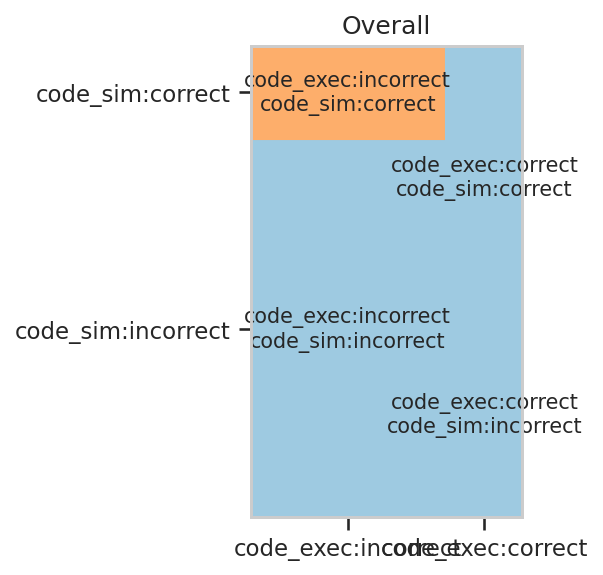

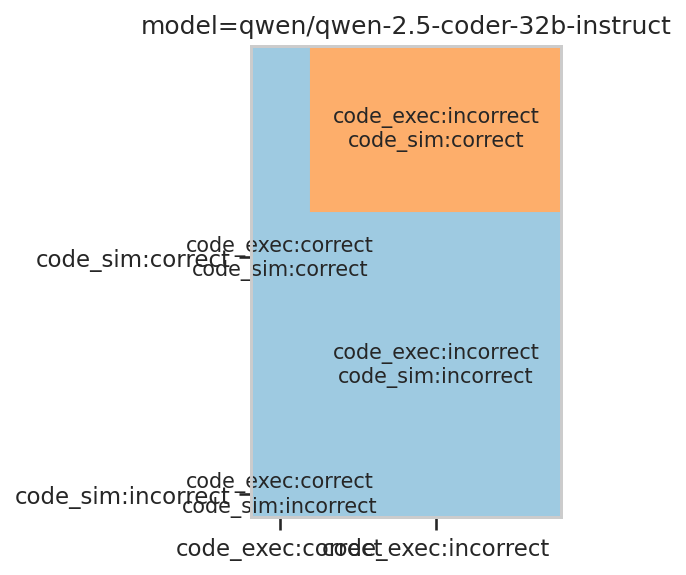

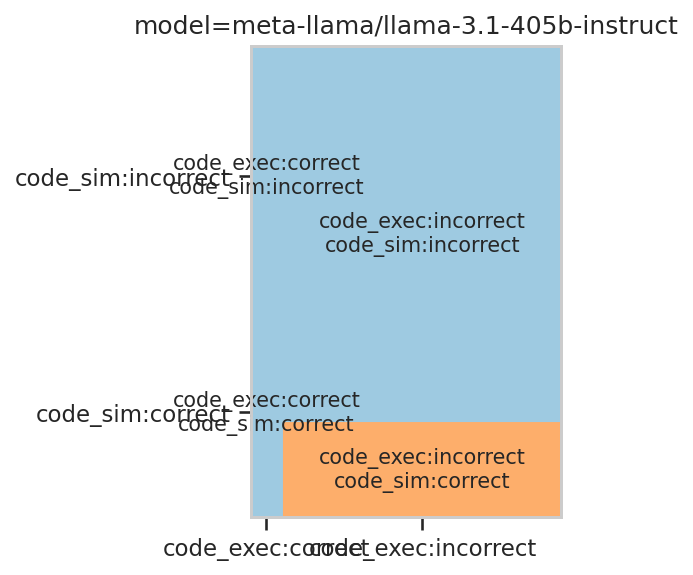

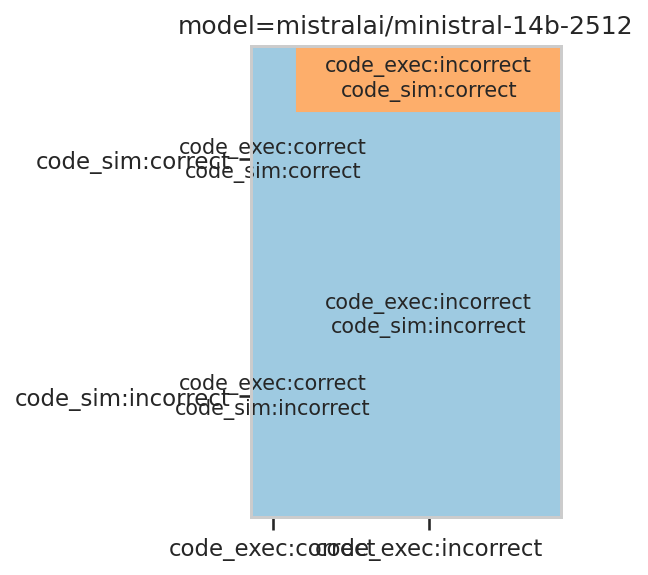

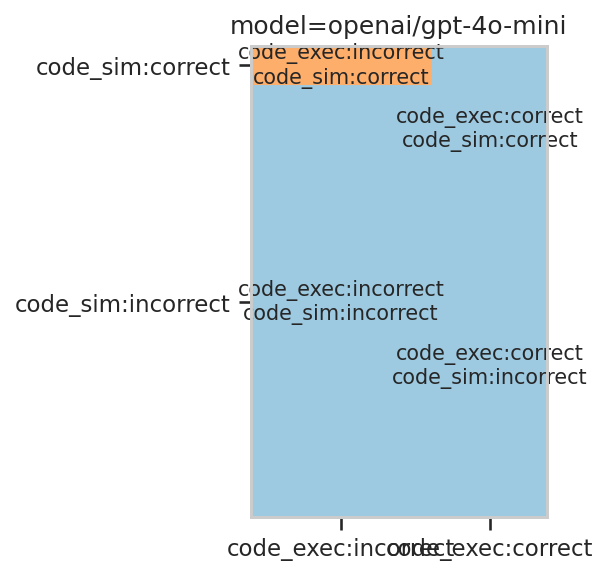

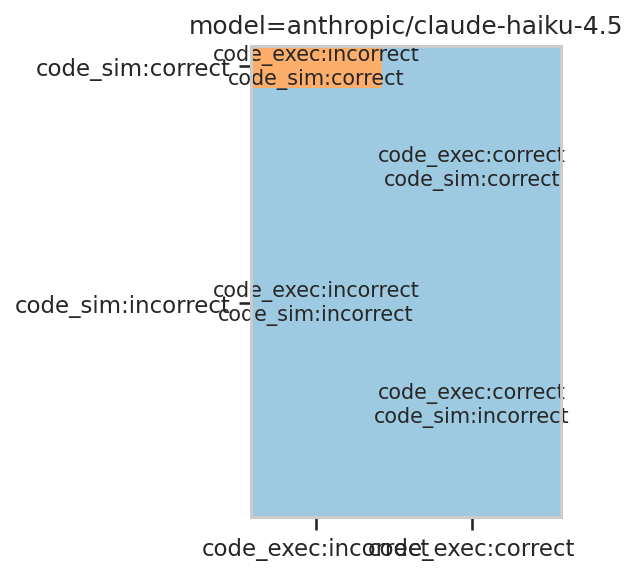

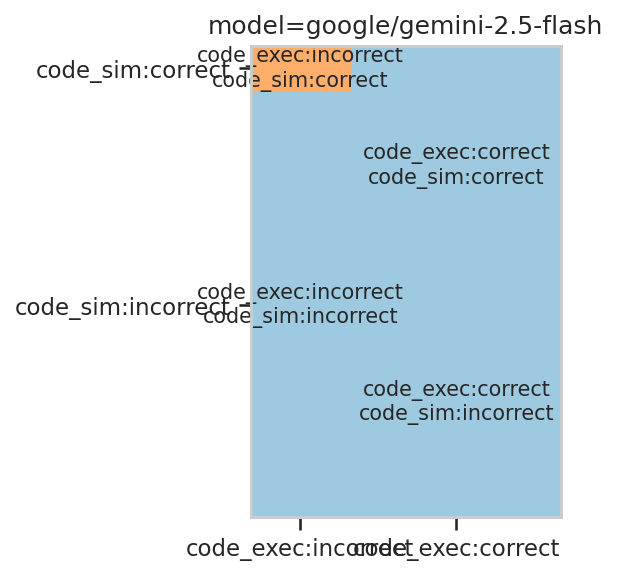

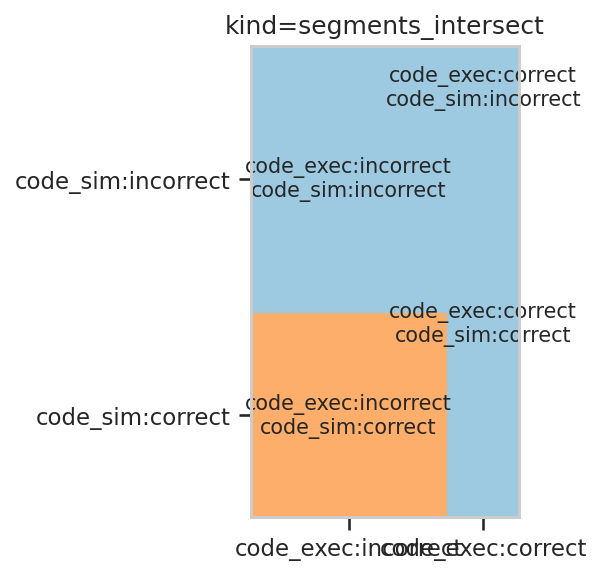

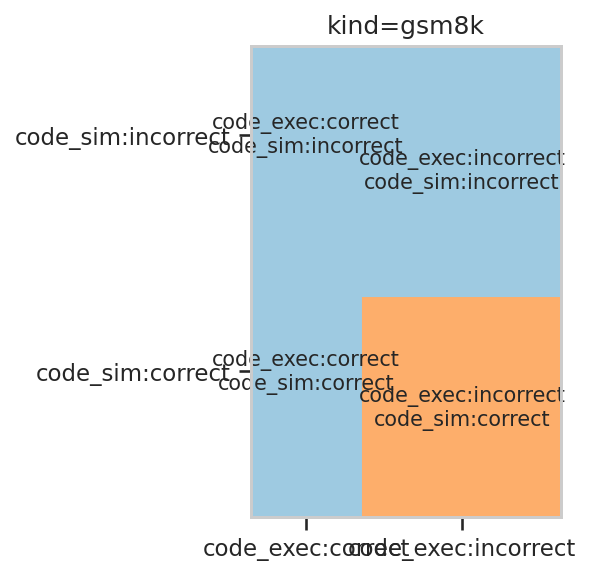

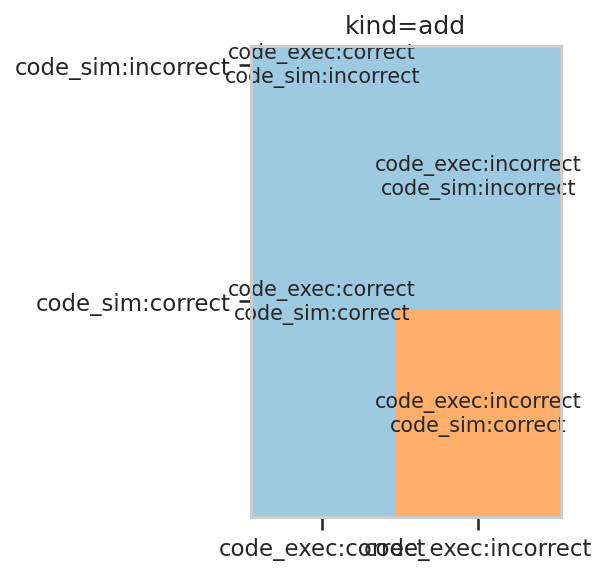

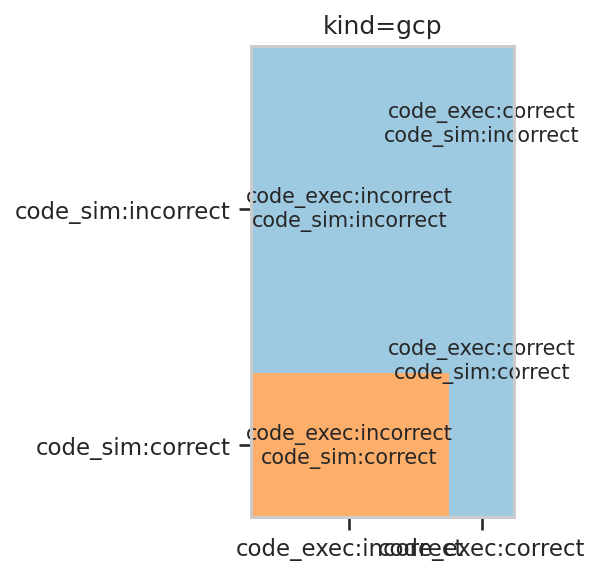

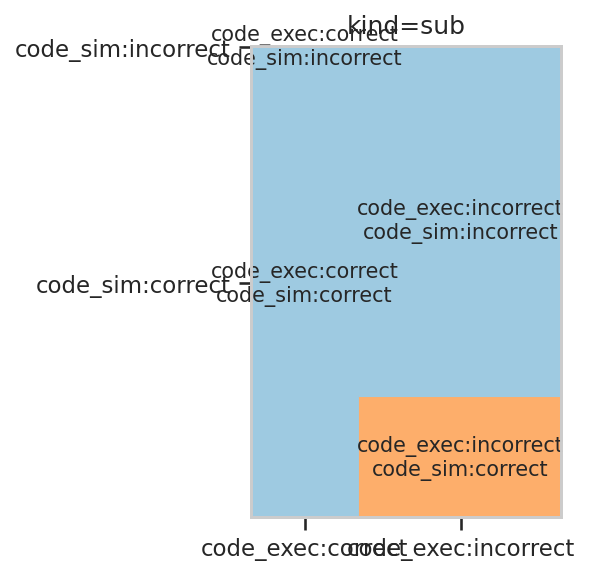

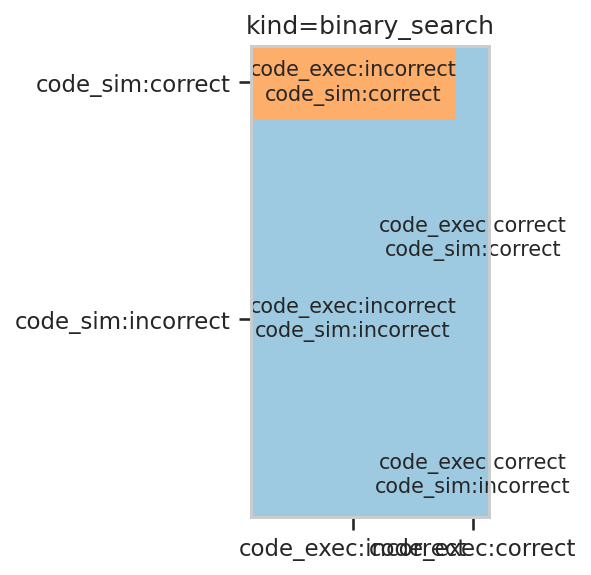

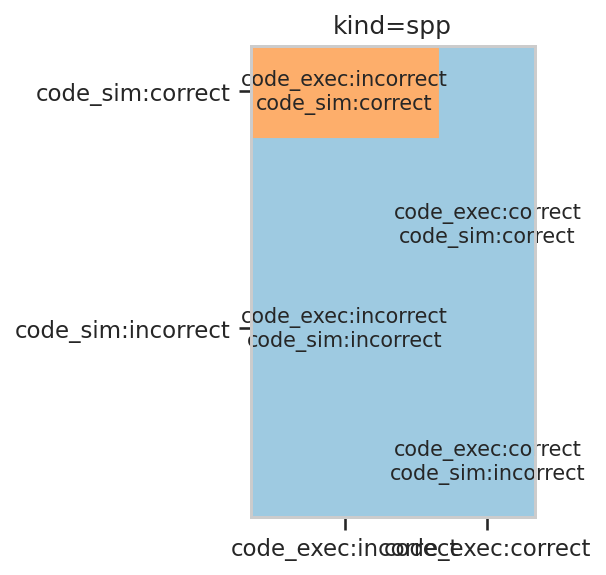

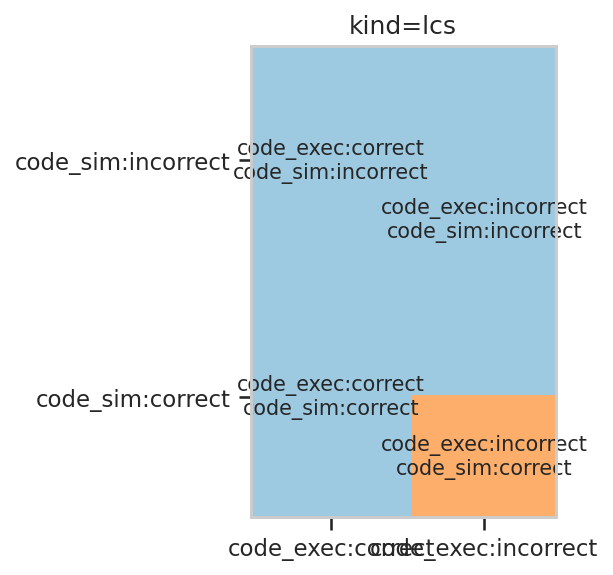

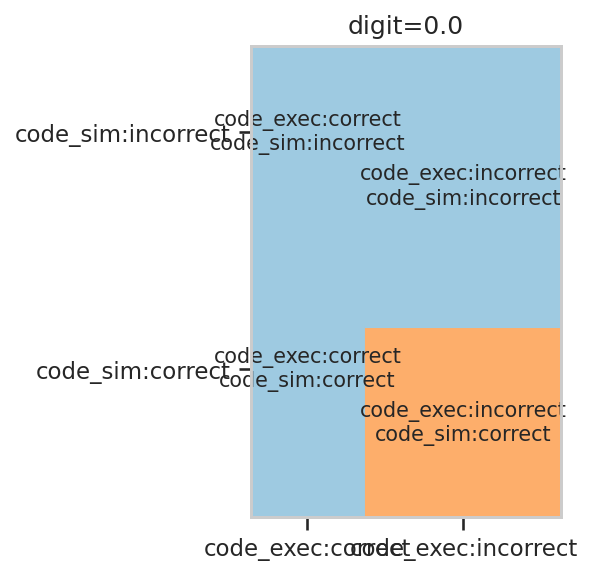

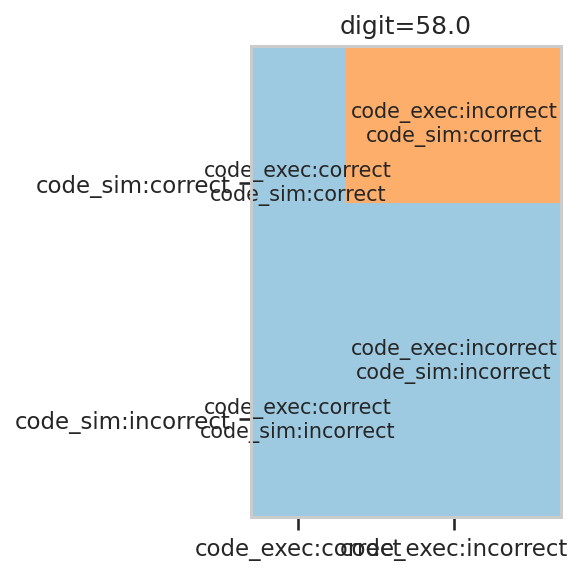

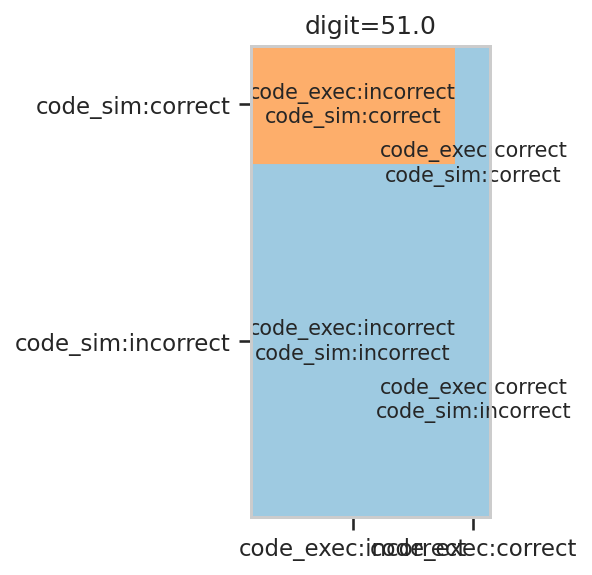

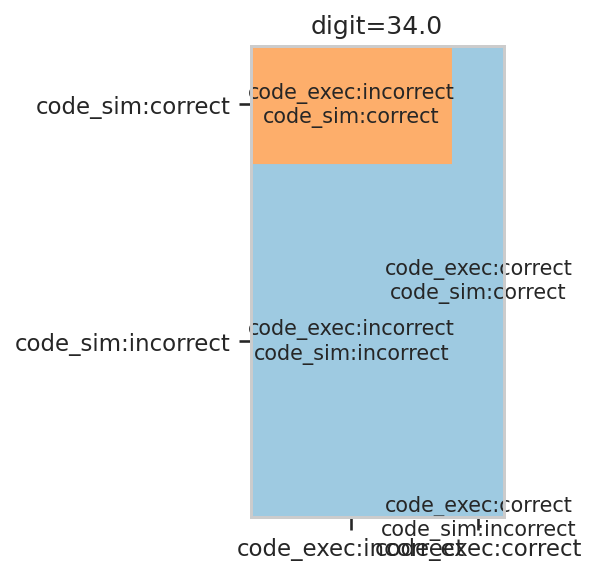

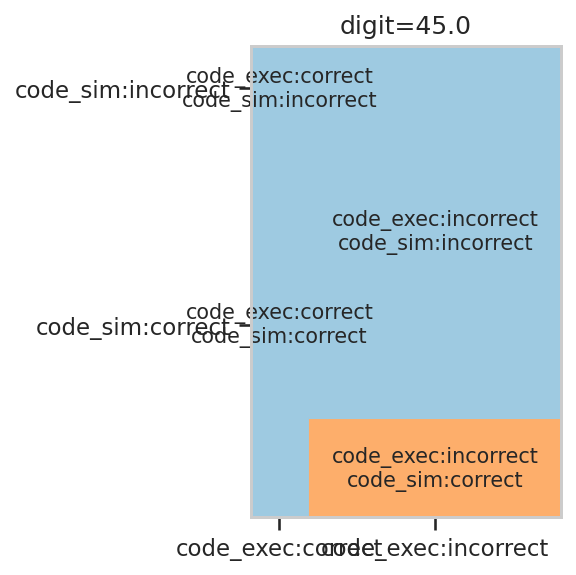

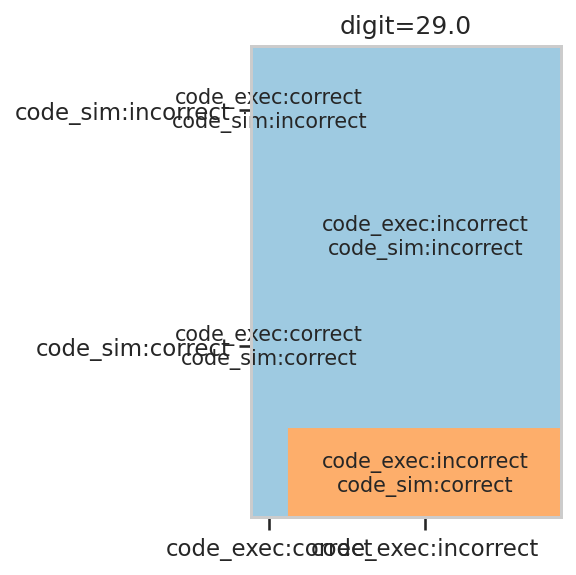

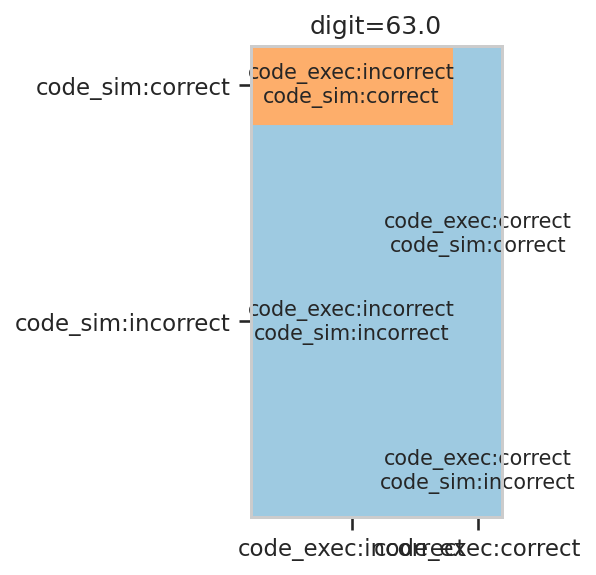

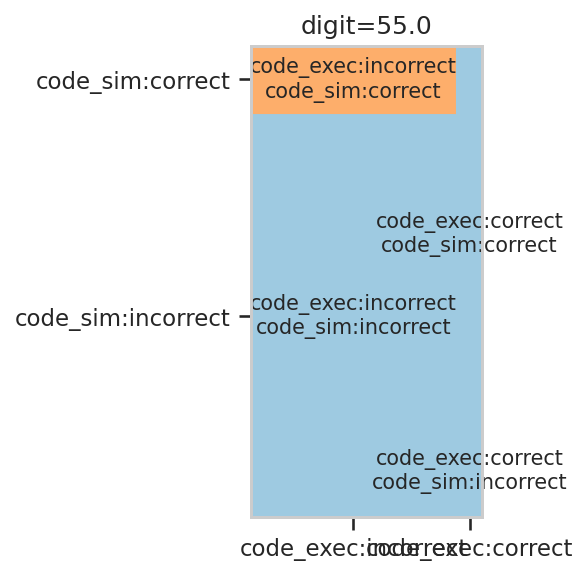

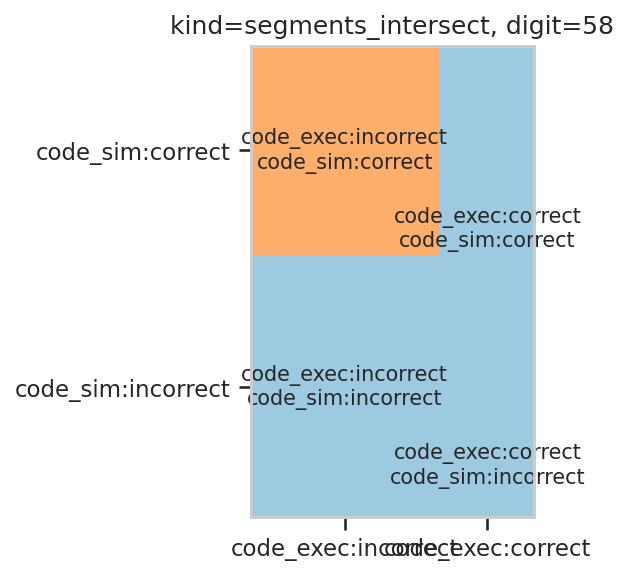

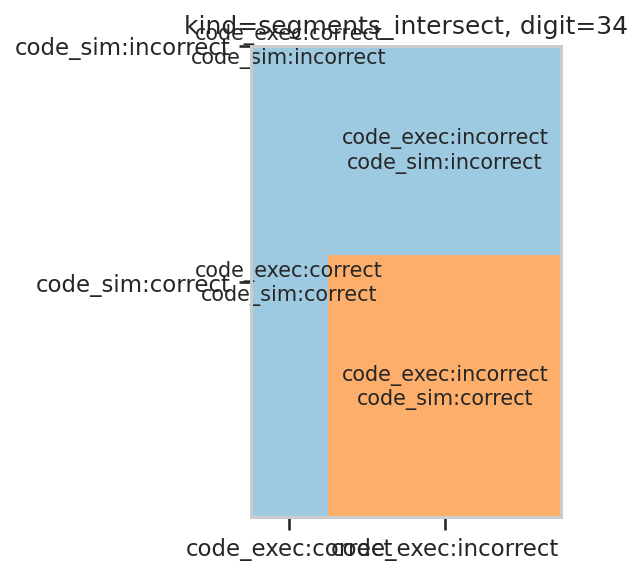

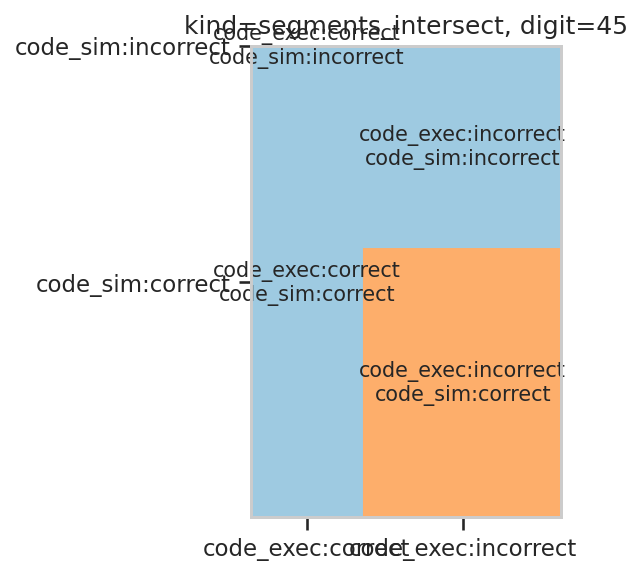

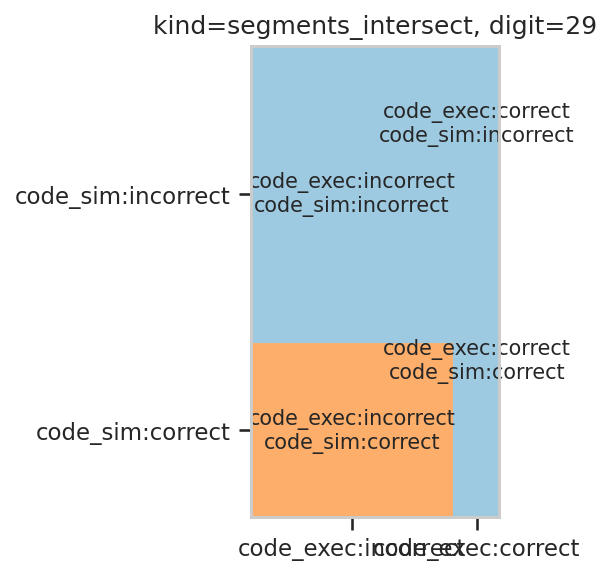

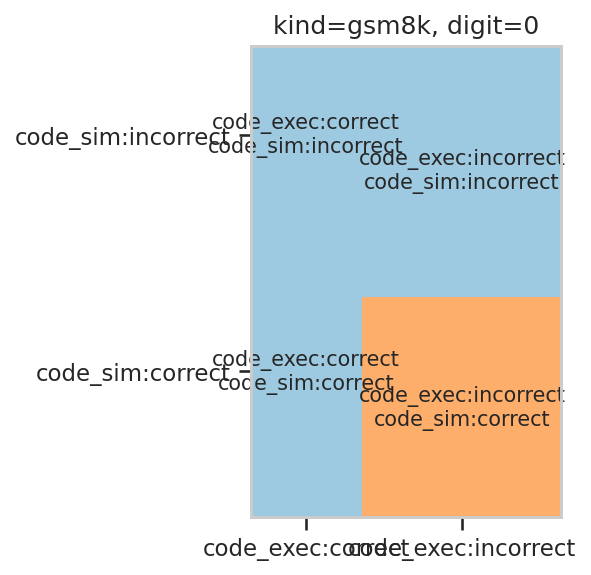

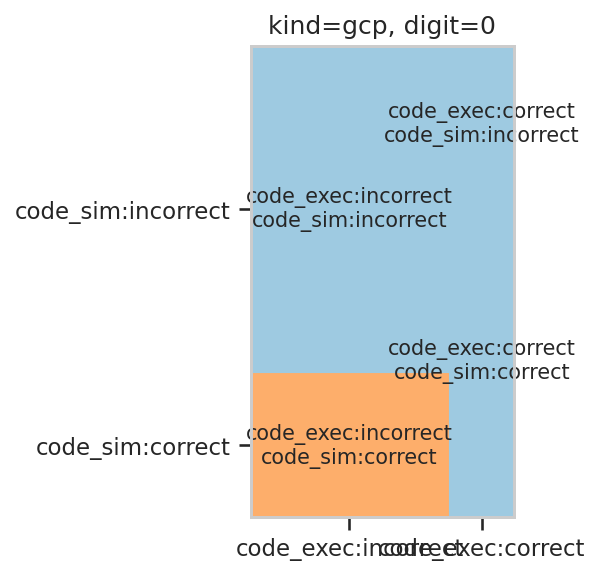

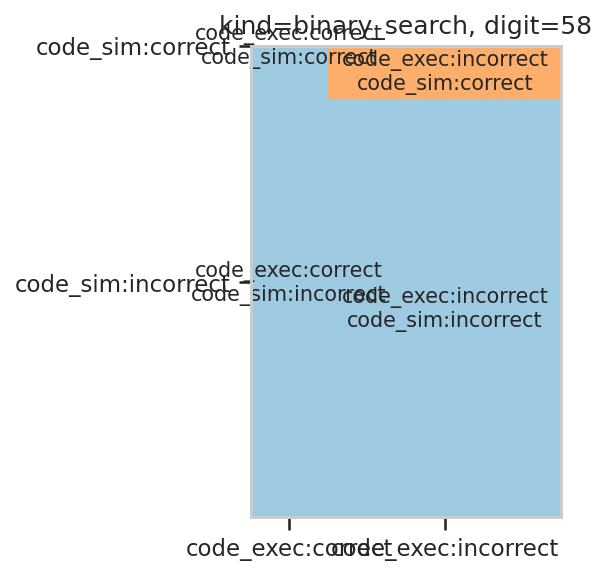

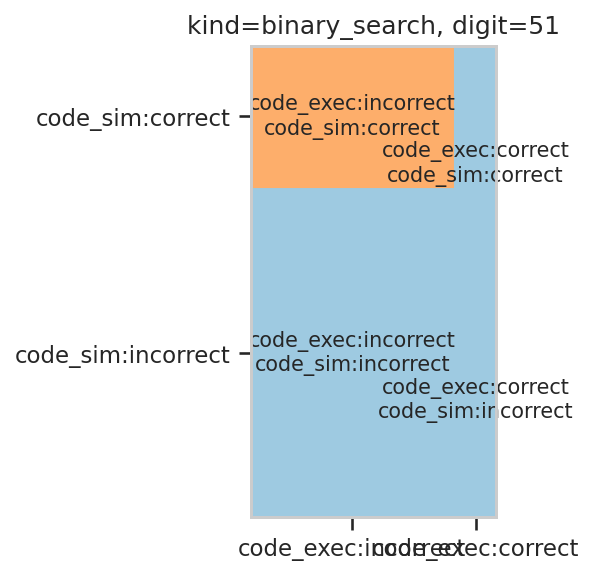

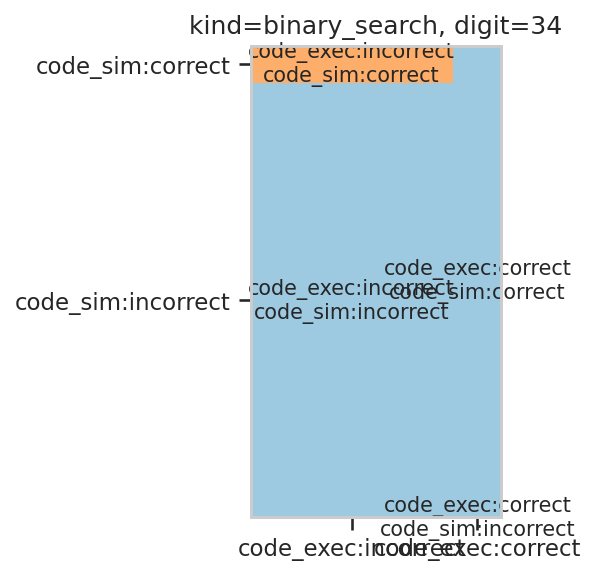

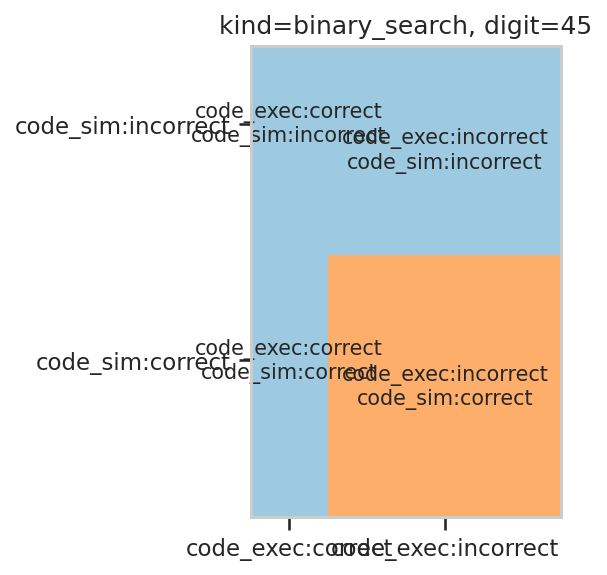

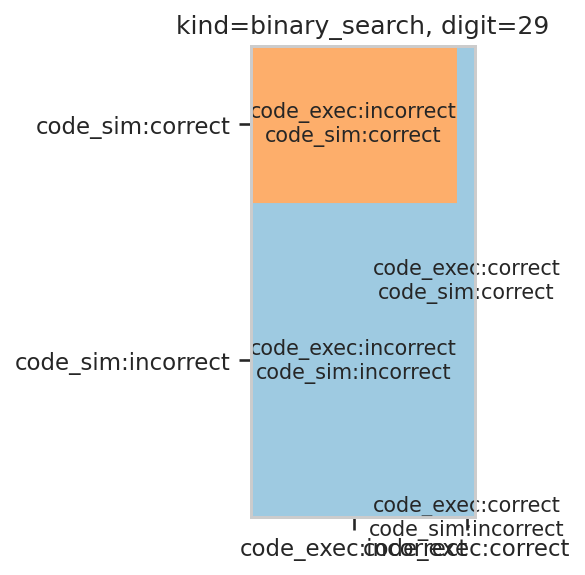

In [27]:
OUTDIR = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/figures/recovery_mosaic")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Overall mosaic
mosaic_plot(df, title="Overall", save_path=OUTDIR / "mosaic_overall.png")

# Breakdown mosaics
plot_top_groups(df, "model", top_n=6, outdir=OUTDIR)
plot_top_groups(df, "kind", top_n=8, outdir=OUTDIR)
plot_top_groups(df, "digit", top_n=8, outdir=OUTDIR)

# Crossed breakdowns for high-signal slices
plot_by_kind_and_digit(df, max_kinds=6, max_digits=6, outdir=OUTDIR)


## Notes and Interpretation Guide
- **Recovery definition**: cases where code execution is wrong (`code_correct=False`) but code simulation is right (`sim_correct=True`).
- **Tables**: check `rates_by_*` DataFrames for high recovery pockets; sort by `recovery_rate` or filter by `total` to avoid noise from tiny samples.
- **Mosaic plots**: recovery quadrant is highlighted in orange. Larger orange areas indicate stronger recovery effects.
- **Next steps**: tighten filters (e.g., minimum `total`), slice by seeds, or add confidence intervals to recovery rates if needed.